#                                                   Modelisation:

## XGBoost: 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import shap
import matplotlib.pyplot as plt

/Users/khadijaaassi/Desktop/Simplon/Projet_devIA/Simplon_SBA-modelisation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df=pd.read_csv('cleaned_data.csv')
df

,MIS_Status,LoanNr_ChkDgt,State,Zip,UrbanRural,Bank,BankState,NAICS,NoEmp,NewExist,...,FranchiseCode,IsFranchise,Term,RevLineCr,LowDoc,DisbursementGross,ApprovalDate,ApprovalFY,GrAppv,SBA_Appv
0,1,1000014003,IN,47711,0,FIFTH THIRD BANK,OH,451120,4,2.0,...,1,1,84,0,1,60000.0,1997-02-28,1997,60000.0,48000.0
1,1,1000024006,IN,46526,0,1ST SOURCE BANK,IN,722410,2,2.0,...,1,1,60,0,1,40000.0,1997-02-28,1997,40000.0,32000.0
2,1,1000034009,IN,47401,0,GRANT COUNTY STATE BANK,IN,621210,7,1.0,...,1,1,180,0,0,287000.0,1997-02-28,1997,287000.0,215250.0
3,1,1000044001,OK,74012,0,1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,...,1,1,60,0,1,35000.0,1997-02-28,1997,35000.0,28000.0
4,1,1000054004,FL,32801,0,FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,...,1,1,240,0,0,229000.0,1997-02-28,1997,229000.0,229000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,1,9995573004,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,6,1.0,...,1,1,60,0,0,70000.0,1997-02-27,1997,70000.0,56000.0
899160,1,9995603000,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,6,1.0,...,1,1,60,0,0,85000.0,1997-02-27,1997,85000.0,42500.0
899161,1,9995613003,CA,93455,0,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,26,1.0,...,1,1,108,0,0,300000.0,1997-02-27,1997,300000.0,225000.0
899162,0,9995973006,HI,96830,0,BANK OF HAWAII,HI,0,6,1.0,...,1,1,60,0,1,75000.0,1997-02-27,1997,75000.0,60000.0


In [4]:
label_encoders = {}
categorical_cols = ['Zip', 'State', 'Bank', 'BankState', 'RevLineCr', 'LowDoc', 'MIS_Status']

In [5]:
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le 

In [6]:
features = ['State', 'NAICS', 'ApprovalFY', 'NewExist', 'CreateJob', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'LowDoc', 'GrAppv', 'SBA_Appv', 'Bank', 'Term']


X = df[features] 
y = df['MIS_Status']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)


1ere modélisation, avec un score plutôt pas mal.

In [ ]:
# Création du modèle XGBoost
model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, max_depth=3, learning_rate=0.2, n_estimators=100)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.4f}")


J'ai besoin de faire un fine tuning, regarder un peu plus la doc pour mieux comprendre les implications et utisation du model.

In [ ]:
# Assuming y_true are the actual labels and y_pred are the predicted labels
y_pred = model.predict(X_test)
y_pred_labels = np.round(y_pred)  # Convert probabilities to class labels (for binary classification)

# Metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')  # 'weighted' for multi-class
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')


In [ ]:
print(classification_report(y_test, y_pred_labels))

In [ ]:
xgb.plot_importance(model)
plt.show()


In [ ]:
import xgboost as xgb

# Convert data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define cross-validation parameters
params = {
    'objective': 'binary:logistic',  # Change this for regression or multi-class classification
    'eval_metric': 'logloss'
}

cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics="logloss", as_pandas=True)

# Print CV results
print(cv_results)


## BEST MODEL!


Matrice de confusion :
[[13194  2588]
 [ 1821 72314]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.91      0.91     89917
weighted avg       0.95      0.95      0.95     89917

ROC AUC Score: 0.9801

Feature Importance (XGBoost) :
State: 0.0161
NAICS: 0.0139
ApprovalFY: 0.1191
NewExist: 0.0148
RetainedJob: 0.0140
FranchiseCode: 0.0355
UrbanRural: 0.0376
GrAppv: 0.0213
SBA_Appv: 0.0259
Bank: 0.0241
Term: 0.2429
ApprovalFY_Term_Ratio: 0.4346


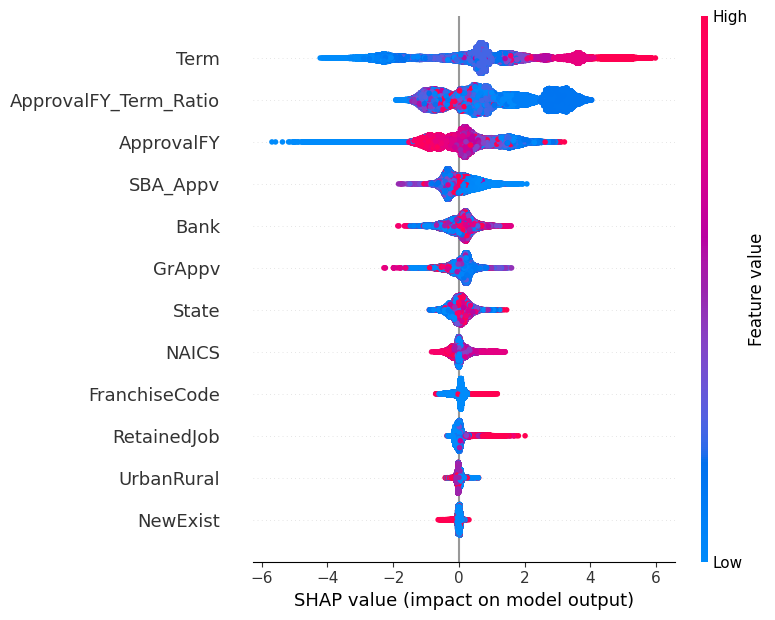

In [12]:
# Standardisation des colonnes monétaires
monetary_cols = ['GrAppv', 'SBA_Appv', 'DisbursementGross']
scaler = StandardScaler()
df[monetary_cols] = scaler.fit_transform(df[monetary_cols])

# Création de nouvelles features (interactions entre variables)
# df['GrAppv_Term_Ratio'] = df['GrAppv'] / (df['Term'] + 1)
# df['SBA_Appv_Term_Ratio'] = df['SBA_Appv'] / (df['Term'] + 1)
df['ApprovalFY_Term_Ratio'] = df['ApprovalFY'] / (df['Term'] + 1)

# Séparation des features et de la cible
features = ['State', 'NAICS', 'ApprovalFY', 'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'SBA_Appv', 'Bank', 'Term',
            'ApprovalFY_Term_Ratio']
X = df[features]
y = df['MIS_Status']

# Vérification du déséquilibre des classes
class_counts = y.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1] if class_counts[1] != 0 else 1

# Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

# Définition du modèle XGBoost avec hyperparamètres ajustés pour améliorer le F1-score de la classe 0
best_model = xgb.XGBClassifier(
    max_depth=6,  # Augmenter la profondeur pour capturer plus de complexité
    learning_rate=0.15,  # Ajuster le taux d'apprentissage
    n_estimators=250,  # Augmenter le nombre d'estimateurs
    subsample=0.9,  # Légère augmentation de la sous-sampling
    colsample_bytree=0.9,  # Utiliser plus de features par arbre
    scale_pos_weight=scale_pos_weight * 1.4  # Ajuster pour améliorer la détection de la classe 0
)
{'max_depth': 10, 'learning_rate': 0.1362428548659794, 'n_estimators': 362,
  'subsample': 0.973051842684875, 'colsample_bytree': 0.8460830471606468, 'scale_pos_weight': 1.075431778029177}
# Entraînement du modèle
best_model.fit(X_train, y_train)

# Ajustement du seuil de classification
threshold = 0.25  # Ajustement pour mieux détecter la classe 0
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > threshold).astype(int)

# Prédictions et évaluation
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Score ROC AUC (uniquement si binaire)
if len(np.unique(y_test)) == 2:
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f'ROC AUC Score: {roc_auc:.4f}')

# Importance des features avec XGBoost
print("\nFeature Importance (XGBoost) :")
feature_importances = best_model.feature_importances_
for col, importance in zip(features, feature_importances):
    print(f'{col}: {importance:.4f}')

# SHAP pour interprétabilité
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


# Optuna

In [7]:
df['ApprovalFY_Term_Ratio'] = df['ApprovalFY'] / (df['Term'] + 1)

# Séparation des features et de la cible
features = ['State', 'NAICS', 'ApprovalFY', 'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'SBA_Appv', 'Bank', 'Term',
            'ApprovalFY_Term_Ratio']
X = df[features]
y = df['MIS_Status']

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score

# Définition de la fonction objectif pour Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 3.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return roc_auc(y_test, y_pred, average='weighted')


# Chargement des données (à adapter si nécessaire)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

# Lancer l'optimisation Optuna
study = optuna.create_study(direction='maximize', study_name="Xgbm_study2", storage="sqlite:///optuna_study.db")
study.optimize(objective, n_trials=50)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", study.best_params)

# Entraîner le modèle avec les meilleurs paramètres
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Prédictions et évaluation finale
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Calcul et affichage du ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')


[I 2025-02-10 13:38:49,541] A new study created in RDB with name: Xgbm_study2
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_36530/2296840281.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.2),
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_36530/2296840281.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_36530/2296840281.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

Meilleurs hyperparamètres : {'max_depth': 7, 'learning_rate': 0.19868166605667176, 'n_estimators': 235, 'subsample': 0.9501710916808656, 'colsample_bytree': 0.9806974931299531, 'scale_pos_weight': 1.8472708601238095}

Matrice de confusion :
[[12536  3246]
 [ 1163 72972]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.94      0.89      0.91     89917
weighted avg       0.95      0.95      0.95     89917

ROC AUC Score: 0.9816
